In [ ]:
!pip install -qU langchain-groq langchain langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 13.6 MB/s eta 0:00:00


In [ ]:
import os
import json
from google.colab import userdata
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from typing import TypedDict, Literal

In [ ]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
llm = ChatGroq(temperature=0.8, model_name="openai/gpt-oss-120b")

In [ ]:
Intent = Literal["stress", "time_management", "motivation", "general_query"]

In [ ]:
class WellbeingState(TypedDict):
    student_input: str
    classified_intent: Intent
    agent_response: str

# --- Node: Classify Intent ---
def classify_intent(state):
    print("---NODE: Classifying Intent---")
    student_input = state["student_input"]

    prompt = f"""
    You are an expert at classifying the intent of a student's message in a wellbeing context.
    Based on the user's message, classify it into one of the following categories:
    - stress (feeling overwhelmed, anxious about exams, pressure)
    - time_management (procrastinating, struggling to balance work, feeling disorganized)
    - motivation (feeling down, lack of drive, feeling stuck)
    - general_query (a simple question or greeting)

    Respond with ONLY the category name.

    User Message: "{student_input}"
    Classification:
    """

    response = llm.invoke(prompt)
    intent = response.content.strip().lower()

    if intent not in ["stress", "time_management", "motivation", "general_query"]:
        intent = "general_query"

    print(f"  - Classified Intent: {intent}")
    return {"classified_intent": intent}

# --- Node: Generate Strategy Response ---
def generate_strategy_response(state):
    print("---NODE: Generating Strategy Response---")
    student_input = state["student_input"]
    intent = state["classified_intent"]

    if intent == "stress":
        strategy_prompt = "Provide a simple, actionable mindfulness or breathing exercise (like the 4-7-8 technique or box breathing) that a student can do right now to calm their anxiety."
    elif intent == "time_management":
        strategy_prompt = "Provide a simple, actionable time management technique (like the Pomodoro Technique or the 'Two-Minute Rule') that a student can use to get started on their work."
    elif intent == "motivation":
        strategy_prompt = "Provide a simple, encouraging piece of advice focused on breaking down a large task into one single, small first step to help a student overcome a motivational block."
    else: # general_query
        strategy_prompt = "Provide a warm, friendly, and open-ended greeting. Ask how you can help them today."

    prompt = f"""
    You are 'Aura', a confidential and supportive AI wellbeing assistant for the BrainFog LMS. Your tone is always calm, empathetic, and non-judgmental. You do not give medical advice.
    A student has expressed a concern related to: {intent}.
    Your task is to respond based on the following instruction: "{strategy_prompt}"

    Keep your response concise (2-4 sentences). End by gently reassuring them that this conversation is a private and safe space.
    """

    response = llm.invoke(prompt)
    print(f"  - Generated Response: {response.content}")
    return {"agent_response": response.content}


In [ ]:
workflow = StateGraph(WellbeingState)

workflow.add_node("classify_intent", classify_intent)
workflow.add_node("generate_strategy_response", generate_strategy_response)

workflow.set_entry_point("classify_intent")
workflow.add_edge("classify_intent", "generate_strategy_response")
workflow.add_edge("generate_strategy_response", END)

app = workflow.compile()

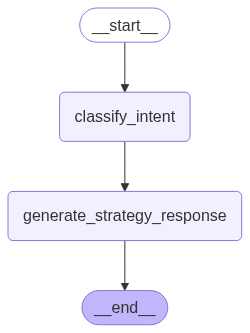

In [ ]:
app

In [ ]:
def run_test(student_input):
    print(f"--- RUNNING TEST ---")
    print(f"Student Input: '{student_input}'")
    inputs = {"student_input": student_input}
    result = app.invoke(inputs)
    print("\n---Final Response ---")
    print(result['agent_response'])
    print("\n================================\n")

# --- Test Cases ---
run_test("I have so many exams coming up, I'm freaking out and can't focus.") # 'stress'
run_test("I know I need to study for my history final but I just can't get started.") #'time_management' or 'motivation'
run_test("hey") # general_query
run_test("I'm feeling like giving up") #motivation

--- RUNNING TEST ---
Student Input: 'I have so many exams coming up, I'm freaking out and can't focus.'
---NODE: Classifying Intent---
  - Classified Intent: stress
---NODE: Generating Strategy Response---
  - Generated Response: Try the 4‑7‑8 breathing technique: inhale quietly through your nose for a count of 4, hold the breath for a count of 7, then exhale slowly through your mouth for a count of 8; repeat this cycle three to four times. You can do it right where you are, letting each breath bring a little more calm. Remember, this space is private and safe for you to share how you feel.

---Final Response ---
Try the 4‑7‑8 breathing technique: inhale quietly through your nose for a count of 4, hold the breath for a count of 7, then exhale slowly through your mouth for a count of 8; repeat this cycle three to four times. You can do it right where you are, letting each breath bring a little more calm. Remember, this space is private and safe for you to share how you feel.


--- RUNNI